# Sea Ice Logistic Predictive Model

In [1]:
#Importing libraries

import numpy as np
import pandas as pd
from sklearn import model_selection
import scipy.optimize as optimal
import matplotlib.pyplot as plt
import scipy
from datetime import date

## Data Preprocessing

In [2]:
#Reading the csv file
data = pd.read_csv('seaice.csv')
data

,Year,Month,Day,Extent,Missing,Source Data,hemisphere
0,1978,10,26,10.231,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,north
1,1978,10,28,10.420,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,north
2,1978,10,30,10.557,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,north
3,1978,11,1,10.670,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,north
4,1978,11,3,10.777,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,north
...,...,...,...,...,...,...,...
26349,2019,5,27,10.085,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsidc...,south
26350,2019,5,28,10.078,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsidc...,south
26351,2019,5,29,10.219,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsidc...,south
26352,2019,5,30,10.363,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsidc...,south


In [3]:
#Renaming columns to get remove any unknown errors
data.columns = ['Year', 'Month', 'Day','Extent', 'Missing', 'Source', 'Hemisphere']

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26354 entries, 0 to 26353
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        26354 non-null  int64  
 1   Month       26354 non-null  int64  
 2   Day         26354 non-null  int64  
 3   Extent      26354 non-null  float64
 4   Missing     26354 non-null  float64
 5   Source      26354 non-null  object 
 6   Hemisphere  26354 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 1.4+ MB


In [5]:
data['Missing'].unique()

array([0.   , 0.001, 0.021, 0.018, 0.024])

In [6]:
#Deleting 'Source' and 'Missing' columns from the dataframe.
#This is because 'Source' column is not relevant to the model we will be creating later.
#We are deleting the 'Missing' column since the values are too small to be relevant for the model.
data.drop(['Source', 'Missing'], inplace=True, axis='columns')

In [7]:
#Splitting the dataset based on the Hemisphere
grouped = data.groupby(data.Hemisphere)
data_south = grouped.get_group("south")
data_north = grouped.get_group("north")

data_south

,Year,Month,Day,Extent,Hemisphere
13177,1978,10,26,17.624,south
13178,1978,10,28,17.803,south
13179,1978,10,30,17.670,south
13180,1978,11,1,17.527,south
13181,1978,11,3,17.486,south
...,...,...,...,...,...
26349,2019,5,27,10.085,south
26350,2019,5,28,10.078,south
26351,2019,5,29,10.219,south
26352,2019,5,30,10.363,south


In [8]:
data_south.drop('Hemisphere', axis=1, inplace=True)
data_north.drop('Hemisphere', axis=1, inplace=True)

/Users/bhavnasharma/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [9]:
# Adding time element called "Datapoints"
a=[]
for i in range(1,13178):
    a.append(i)
data_south.insert(3, column = "Datapoints", value = a) 

data_south

,Year,Month,Day,Datapoints,Extent
13177,1978,10,26,1,17.624
13178,1978,10,28,2,17.803
13179,1978,10,30,3,17.670
13180,1978,11,1,4,17.527
13181,1978,11,3,5,17.486
...,...,...,...,...,...
26349,2019,5,27,13173,10.085
26350,2019,5,28,13174,10.078
26351,2019,5,29,13175,10.219
26352,2019,5,30,13176,10.363


## Visualising The Data

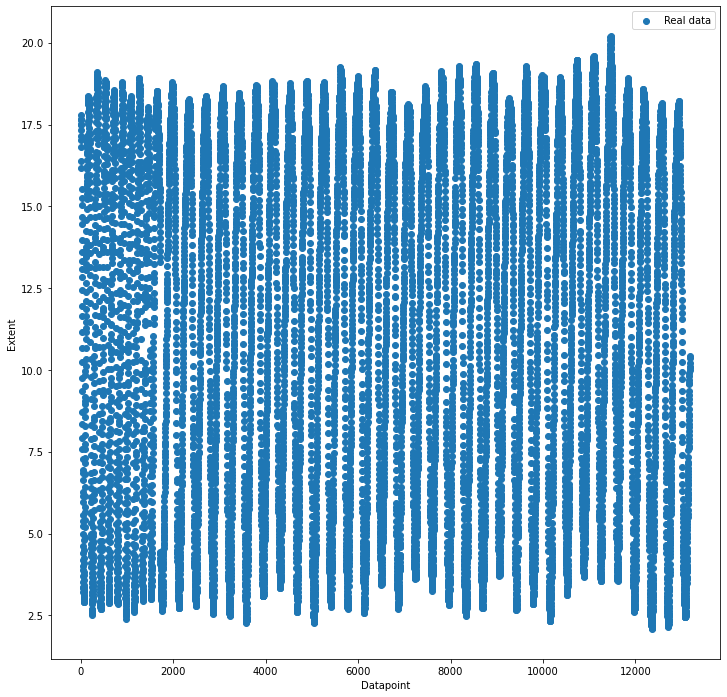

In [10]:
p = np.array(data_south['Datapoints'])
q = np.array(data_south['Extent'])

plt.figure(figsize=(12,12))
plt.scatter(p,q)


plt.legend(['Real data'])
plt.xlabel('Datapoint')
plt.ylabel('Extent')
plt.show()

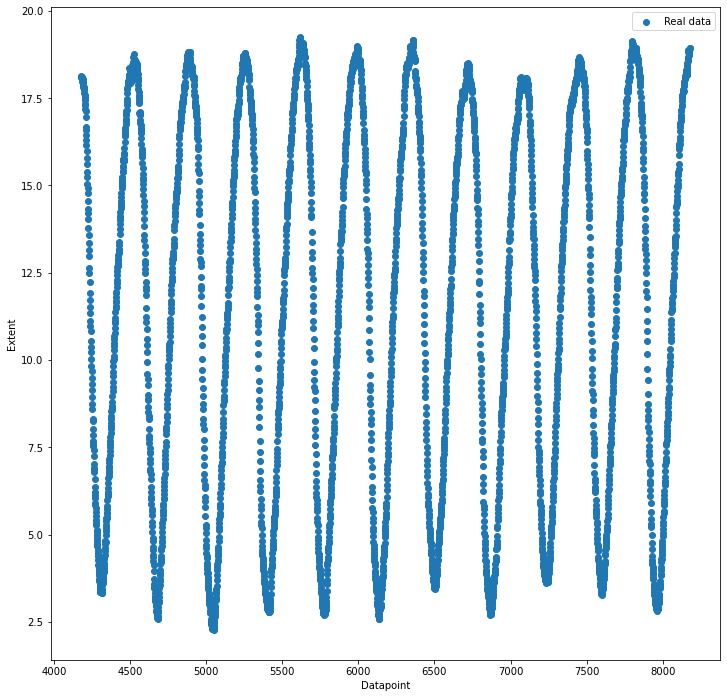

In [11]:
#We are zooming in on the data to visualise it better.
data_south_v= data_south.iloc[-9000:-5000,:]

p = np.array(data_south_v['Datapoints'])
q = np.array(data_south_v['Extent'])

plt.figure(figsize=(12,12))
plt.scatter(p,q)


plt.legend(['Real data'])
plt.xlabel('Datapoint')
plt.ylabel('Extent')
plt.show()

### As we can see above, our data follows a cycle of logistic growth and decay; we will develop our model accordingly.

## Splitting Data Into Train And Test (Predict) 

In [12]:
#Taking out holdout(test) data (for later forecasts)
data_south_predict = data_south.iloc[-5000:,:]

data_south_predict

,Year,Month,Day,Datapoints,Extent
21354,2005,9,22,8178,18.975
21355,2005,9,23,8179,19.061
21356,2005,9,24,8180,19.136
21357,2005,9,25,8181,19.204
21358,2005,9,26,8182,19.240
...,...,...,...,...,...
26349,2019,5,27,13173,10.085
26350,2019,5,28,13174,10.078
26351,2019,5,29,13175,10.219
26352,2019,5,30,13176,10.363


In [13]:
#Removing test data from train data
data_south = data_south.iloc[:-5000,:]

data_south

,Year,Month,Day,Datapoints,Extent
13177,1978,10,26,1,17.624
13178,1978,10,28,2,17.803
13179,1978,10,30,3,17.670
13180,1978,11,1,4,17.527
13181,1978,11,3,5,17.486
...,...,...,...,...,...
21349,2005,9,17,8173,18.746
21350,2005,9,18,8174,18.868
21351,2005,9,19,8175,18.858
21352,2005,9,20,8176,18.938


### Since our data is in a periodic cycle of logistic growth and decay, we are going to analyse both cycles and optimise them separately. 

## Logistic Growth Model

In [14]:
#Below represents the logistic growth model.
#For constants a, b, and c, the logistic growth model over time t is as follows:
#c / (1 + a * np.exp(-b * t))
#The growth rate for this can be obtained by calculating the differential equation, which is 
#dp/dt = kP(1-(P/K))
def my_logistic_growth1(t, a, b, c):
    return c / (1 + a * np.exp(-b * t))

In [15]:
p0 = np.random.exponential(size=3)

p0

array([0.72613492, 1.03855053, 0.17947421])

In [16]:
bounds = (0, [1000., 10., 1000000000.])

In [17]:
#After running multiple simulations of different lengths of cycles, we found 220 to be 
#the most optimised cycle on our training set.

data_growth = data_south.iloc[-220:,:]

data_growth

,Year,Month,Day,Datapoints,Extent
21134,2005,2,14,7958,2.883
21135,2005,2,15,7959,2.865
21136,2005,2,16,7960,2.844
21137,2005,2,17,7961,2.832
21138,2005,2,18,7962,2.804
...,...,...,...,...,...
21349,2005,9,17,8173,18.746
21350,2005,9,18,8174,18.868
21351,2005,9,19,8175,18.858
21352,2005,9,20,8176,18.938


In [18]:
#Restarting our "Datapoints" from the first date of observation.
data_growth.drop('Datapoints', inplace=True, axis=1)

a=[]
for i in range(1,221):
    a.append(i)
data_growth.insert(3, column = "Datapoints", value = a) 

data_growth

/Users/bhavnasharma/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Year,Month,Day,Datapoints,Extent
21134,2005,2,14,1,2.883
21135,2005,2,15,2,2.865
21136,2005,2,16,3,2.844
21137,2005,2,17,4,2.832
21138,2005,2,18,5,2.804
...,...,...,...,...,...
21349,2005,9,17,216,18.746
21350,2005,9,18,217,18.868
21351,2005,9,19,218,18.858
21352,2005,9,20,219,18.938


In [19]:
x = np.array(data_growth['Datapoints'])
y = np.array(data_growth['Extent'])

#Optimising the values of a, b, and c according to our logistic growth function and x and y train data.

(a, b, c), cov = optimal.curve_fit(my_logistic_growth1, x, y, bounds = bounds, p0=p0)

In [20]:
#Optimised a,b, and c values according to the above calculations.

a,b,c

(7.588093903922892, 0.022473164106373466, 20.03867466341117)

In [21]:
#Using the above optimised a,b, and c values to show the logistic growth model. 

def my_logistic_growth2(t):
    return c / (1 + a * np.exp(-b * t))

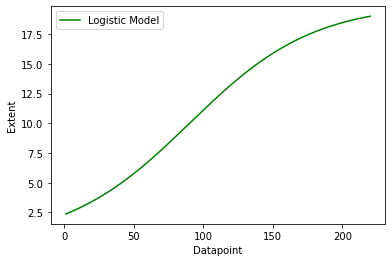

In [22]:
#Logistic growth model according to train "Datapoints".

plt.plot(x, my_logistic_growth2(x), color='green')

plt.legend([ 'Logistic Model'])
plt.xlabel('Datapoint')
plt.ylabel('Extent')
plt.show()

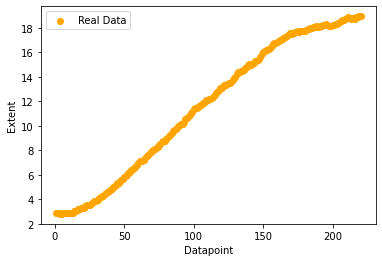

In [23]:
#This is our real data. 

plt.scatter(x,y, color='orange')

plt.legend([ 'Real Data'])
plt.xlabel('Datapoint')
plt.ylabel('Extent')
plt.show()

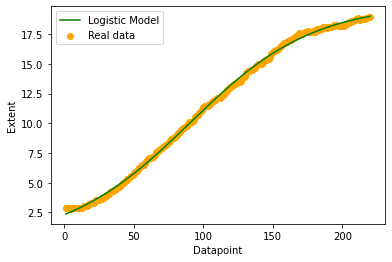

In [24]:
#Comparison of logistic growth model with real data. 

plt.scatter(x,y, color='orange')
plt.plot(x, my_logistic_growth2(x), color='green')

plt.legend([ 'Logistic Model', 'Real data'])
plt.xlabel('Datapoint')
plt.ylabel('Extent')
plt.show()

## Logistic Decay Model

In [25]:
#The logistic decay model equation differs from the logistic growth model equation only in that the exponent is 
#negated. This is done so that when we take the differential equation of this function, the ultimate value is 
#negative(dp/dt = -kP(1-(P/K))), representing decay instead of growth. 

#The constant 'b' is the steepness or slope of our function. If the slope is negative, we get a decay model 
#accordingly.

def my_logistic_decay1(t2, a2, b2, c2):
    return c2 / (1 + a2 * np.exp(-(-b2) * t2))

In [26]:
bounds2 = ([0., 0., 0.], [10000., 10., 100000000000.])

In [27]:
##After running multiple simulations of different lengths of cycles, we found 145 to be the most optimised cycle 
#on our training set.

data_decay = data_south.iloc[-370:-225,:]

data_decay

,Year,Month,Day,Datapoints,Extent
20984,2004,9,17,7808,18.912
20985,2004,9,18,7809,18.913
20986,2004,9,19,7810,18.924
20987,2004,9,20,7811,18.956
20988,2004,9,21,7812,18.939
...,...,...,...,...,...
21124,2005,2,4,7948,3.133
21125,2005,2,5,7949,3.119
21126,2005,2,6,7950,3.097
21127,2005,2,7,7951,3.048


In [28]:
#Restarting our "Datapoints" from the first date of observation.

data_decay.drop('Datapoints', inplace=True, axis=1)

v=[]
for i in range(1,146):
    v.append(i)
data_decay.insert(3, column = "Datapoints", value = v) 

data_decay

/Users/bhavnasharma/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Year,Month,Day,Datapoints,Extent
20984,2004,9,17,1,18.912
20985,2004,9,18,2,18.913
20986,2004,9,19,3,18.924
20987,2004,9,20,4,18.956
20988,2004,9,21,5,18.939
...,...,...,...,...,...
21124,2005,2,4,141,3.133
21125,2005,2,5,142,3.119
21126,2005,2,6,143,3.097
21127,2005,2,7,144,3.048


In [29]:
x2 = np.array(data_decay['Datapoints'])
y2 = np.array(data_decay['Extent'])

#Optimising the values of a2, b2, and c2 according to our logistic decay function and x2 and y2 train data.

(a2, b2, c2), cov2 = optimal.curve_fit(my_logistic_decay1, x2, y2, bounds = bounds2, p0=p0)

In [30]:
#Optimised a2, b2, and c2 values according to the above calculations.

a2,b2,c2

(0.016443431627643973, 0.04355047747602529, 19.626596548272133)

In [31]:
#Using the above optimised a2, b2, and c2 values to show the logistic decay model. 

def my_logistic_decay2(t2):
    return c2 / (1 + a2 * np.exp(-(-b2) * t2))

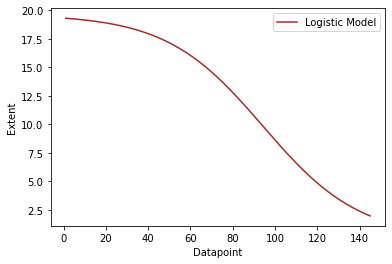

In [32]:
#Logistic decay model according to train "Datapoints".

plt.plot(x2, my_logistic_decay2(x2), color = 'brown')

plt.legend(['Logistic Model', 'Real'])
plt.xlabel('Datapoint')
plt.ylabel('Extent')
plt.show()

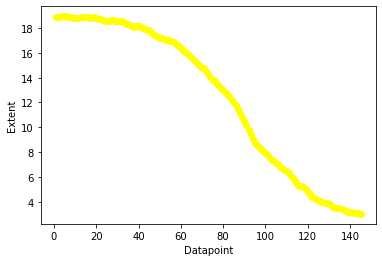

In [33]:
#This is our real data. 

plt.scatter(x2, y2, color='yellow')
plt.xlabel('Datapoint')
plt.ylabel('Extent')
plt.show()

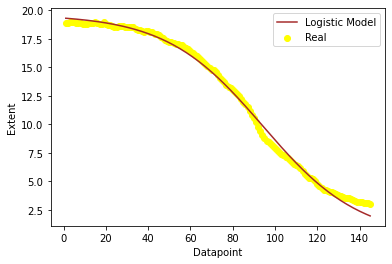

In [34]:
#Comparison of logistic growth model with real data. 

plt.scatter(x2, y2, color='yellow')
plt.plot(x2, my_logistic_decay2(x2), color = 'brown')



plt.legend(['Logistic Model', 'Real'])
plt.xlabel('Datapoint')
plt.ylabel('Extent')
plt.show()

## Cyclic Growth Decay Model

### Using the above growth and decay models, we create a cyclic growth-decay model. This will be used to forecast our future values.

In [35]:
#As we had already found our optimised cycles to be 220 for growth and 145 for decay, we create our cyclic model 
#with the same estimated cycle. 

def predict(l,m,n):
    d0=date(2005,9,21)
    y_model=[]
    w=[]
    for i in range(len(l)):
        d1=date(l[i],m[i],n[i])
        delt=d1-d0
        w.append(delt.days)
    r=1
    for k in w:
        if(k>0):
            g=k
            r=1
            while((r%2!=0 and g>145) or (r%2==0 and g>220)):
                if(k>145):
                    g-=145
                    r+=1
                    if(g>220):
                        g-=220
                        r+=1
            if(r%2!=0):
                y_model.append(my_logistic_decay2(g))
            else:
                y_model.append(my_logistic_growth2(g))
        elif(k==0):
            y_model.append(my_logistic_growth2(220))
        else:
            g=k
            r=1
            while(g<0):
                g+=220
                if(g>0 and r%2==0):
                    r+=1
                if(g==0 and r%2!=0):
                    g=145
                    r+=1
                elif(g==0):
                    g=145
                elif(g<0):
                    g+=145
                    if(r%2!=0):
                        r+=1
                    if(g==0):
                        g=220
                        r+=1
            if(r%2!=0):
                y_model.append(my_logistic_growth2(g))
            else:
                y_model.append(my_logistic_decay2(g))
        
            
    return y_model

In [36]:
#Restarting our "Datapoints" from the first date of forecasting.

data_south_predict.drop('Datapoints', inplace=True, axis=1)

v=[]
for i in range(1,5001):
    v.append(i)
data_south_predict.insert(3, column = "Datapoints", value = v) 

data_south_predict

/Users/bhavnasharma/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Year,Month,Day,Datapoints,Extent
21354,2005,9,22,1,18.975
21355,2005,9,23,2,19.061
21356,2005,9,24,3,19.136
21357,2005,9,25,4,19.204
21358,2005,9,26,5,19.240
...,...,...,...,...,...
26349,2019,5,27,4996,10.085
26350,2019,5,28,4997,10.078
26351,2019,5,29,4998,10.219
26352,2019,5,30,4999,10.363


### Forecasting future data

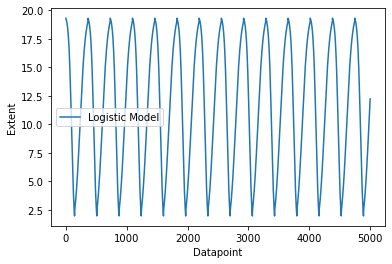

In [37]:
#Predicted logistic model of our holdout data. 

x_pred = np.array(data_south_predict['Datapoints'])
y_pred = np.array(data_south_predict['Extent'])
l = np.array(data_south_predict['Year'])
m = np.array(data_south_predict['Month'])
n = np.array(data_south_predict['Day'])

plt.plot(x_pred, predict(l,m,n))

plt.legend([ 'Logistic Model'])
plt.xlabel('Datapoint')
plt.ylabel('Extent')
plt.show()

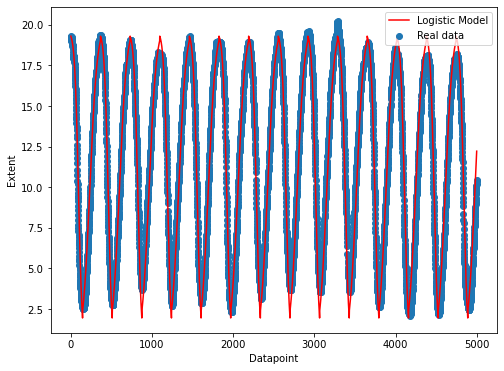

In [38]:
#Comparison of logistic model with real data. 

plt.figure(figsize=(8,6))

plt.scatter(x_pred,y_pred)
plt.plot(x_pred, predict(l,m,n), color='red')

plt.legend([ 'Logistic Model', 'Real data'])
plt.xlabel('Datapoint')
plt.ylabel('Extent')

plt.show()

In [39]:
#Taking 900 records out of the holdout data to zoom in and check.
data_south_predict2 = data_south_predict.iloc[:900,:]

data_south_predict2

,Year,Month,Day,Datapoints,Extent
21354,2005,9,22,1,18.975
21355,2005,9,23,2,19.061
21356,2005,9,24,3,19.136
21357,2005,9,25,4,19.204
21358,2005,9,26,5,19.240
...,...,...,...,...,...
22249,2008,3,5,896,4.370
22250,2008,3,6,897,4.476
22251,2008,3,7,898,4.500
22252,2008,3,8,899,4.530


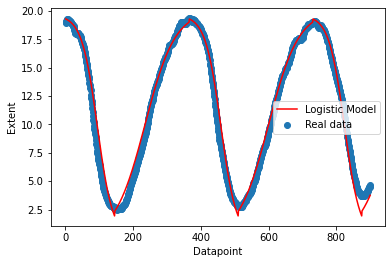

In [40]:
#Predicted logistic model of the 900 records out of the holdout data, including comparison between logistic model
#and real data.

x_pred2 = np.array(data_south_predict2['Datapoints'])
y_pred2 = np.array(data_south_predict2['Extent'])
l2 = np.array(data_south_predict2['Year'])
m2 = np.array(data_south_predict2['Month'])
n2 = np.array(data_south_predict2['Day'])

plt.scatter(x_pred2,y_pred2)
plt.plot(x_pred2, predict(l2,m2,n2), color="red")

plt.legend([ 'Logistic Model', 'Real data'])
plt.xlabel('Datapoint')
plt.ylabel('Extent')

plt.show()

### Hindcasting past data

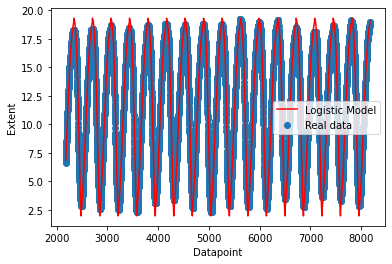

In [41]:
data_south_predict3 = data_south.iloc[-6000:,:]

x_pred3 = np.array(data_south_predict3['Datapoints'])
y_pred3 = np.array(data_south_predict3['Extent'])
l3 = np.array(data_south_predict3['Year'])
m3 = np.array(data_south_predict3['Month'])
n3 = np.array(data_south_predict3['Day'])

plt.scatter(x_pred3,y_pred3)
plt.plot(x_pred3, predict(l3,m3,n3), color="red")

plt.legend([ 'Logistic Model', 'Real data'])
plt.xlabel('Datapoint')
plt.ylabel('Extent')

plt.show()

### Forecasting a near and far future datapoint.

In [42]:
def preddate():
    l4=np.array([int(input("Please enter the year - "))])
    m4=np.array([int(input("Please enter the month - "))])
    n4=np.array([int(input("Please enter the day - "))])

    pred1 = predict(l4,m4,n4)

    print("The predicted extent of Sea Ice on ",l4[0],'/', m4[0],'/',n4[0],' is - ', pred1[0],sep='')
    pr2 = (data_south_predict.Extent[(data_south_predict.Year == l4[0]) 
                                      & (data_south_predict.Month == m4[0]) 
                                      & (data_south_predict.Day == n4[0])].values)[0]
    print("Real data on that day -", pr2)

In [43]:
#Near
preddate()

Please enter the year - 2005
Please enter the month - 9
Please enter the day - 26
The predicted extent of Sea Ice on 2005/9/26 is - 19.2333933597123
Real data on that day - 19.24


In [44]:
## Far
preddate()

Please enter the year - 2010
Please enter the month - 4
Please enter the day - 30
The predicted extent of Sea Ice on 2010/4/30 is - 8.546488756930769
Real data on that day - 8.562000000000001


### Hindcast a near and far past datapoint.

In [45]:
def postdate():
    l5=np.array([int(input("Please enter the year - "))])
    m5=np.array([int(input("Please enter the month - "))])
    n5=np.array([int(input("Please enter the day - "))])

    pred1 = predict(l5,m5,n5)

    print("The predicted extent of Sea Ice on ",l5[0],'/', m5[0],'/',n5[0],' is - ', pred1[0],sep='')
    pr2 = (data_south.Extent[(data_south.Year == l5[0]) 
                                      & (data_south.Month == m5[0]) 
                                      & (data_south.Day == n5[0])].values)[0]
    print("Real data on that day -", pr2)

In [46]:
#Near
postdate()

Please enter the year - 2005
Please enter the month - 6
Please enter the day - 16
The predicted extent of Sea Ice on 2005/6/16 is - 13.555660936317388
Real data on that day - 13.337


In [47]:
#Far
postdate()

Please enter the year - 1991
Please enter the month - 6
Please enter the day - 27
The predicted extent of Sea Ice on 1991/6/27 is - 14.225589191962332
Real data on that day - 14.154000000000002


## Changing Initial Conditions

### 1. Changing the growth cycle by 10 days increase.

In [48]:
data_growth = data_south.iloc[-230:,:]

data_growth

,Year,Month,Day,Datapoints,Extent
21124,2005,2,4,7948,3.133
21125,2005,2,5,7949,3.119
21126,2005,2,6,7950,3.097
21127,2005,2,7,7951,3.048
21128,2005,2,8,7952,3.013
...,...,...,...,...,...
21349,2005,9,17,8173,18.746
21350,2005,9,18,8174,18.868
21351,2005,9,19,8175,18.858
21352,2005,9,20,8176,18.938


In [49]:
#Restarting our "Datapoints" from the first date of forecasting.

data_growth.drop('Datapoints', inplace=True, axis=1)

a=[]
for i in range(1,231):
    a.append(i)
data_growth.insert(3, column = "Datapoints", value = a) 

data_growth

/Users/bhavnasharma/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Year,Month,Day,Datapoints,Extent
21124,2005,2,4,1,3.133
21125,2005,2,5,2,3.119
21126,2005,2,6,3,3.097
21127,2005,2,7,4,3.048
21128,2005,2,8,5,3.013
...,...,...,...,...,...
21349,2005,9,17,226,18.746
21350,2005,9,18,227,18.868
21351,2005,9,19,228,18.858
21352,2005,9,20,229,18.938


In [50]:
#Re-optimising a, b, and c values.

x = np.array(data_growth['Datapoints'])
y = np.array(data_growth['Extent'])

(a, b, c), cov = optimal.curve_fit(my_logistic_growth1, x, y, bounds = bounds, p0=p0)

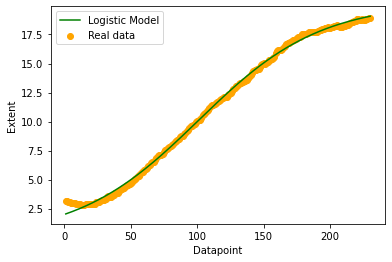

In [51]:
#Not much short term change. 

plt.scatter(x,y, color='orange')
plt.plot(x, my_logistic_growth2(x), color='green')

plt.legend([ 'Logistic Model', 'Real data'])
plt.xlabel('Datapoint')
plt.ylabel('Extent')
plt.show()

In [52]:
#Remaking the model with changed cycles.

def predict(l,m,n):
    d0=date(2005,9,21)
    y_model=[]
    w=[]
    for i in range(len(l)):
        d1=date(l[i],m[i],n[i])
        delt=d1-d0
        w.append(delt.days)
    r=1
    for k in w:
        if(k>0):
            g=k
            r=1
            while((r%2!=0 and g>145) or (r%2==0 and g>230)):
                if(k>145):
                    g-=145
                    r+=1
                    if(g>230):
                        g-=230
                        r+=1
            if(r%2!=0):
                y_model.append(my_logistic_decay2(g))
            else:
                y_model.append(my_logistic_growth2(g))
        elif(k==0):
            y_model.append(my_logistic_growth2(230))
        else:
            g=k
            r=1
            while(g<0):
                g+=230
                if(g>0 and r%2==0):
                    r+=1
                if(g==0 and r%2!=0):
                    g=145
                    r+=1
                elif(g==0):
                    g=145
                elif(g<0):
                    g+=145
                    if(r%2!=0):
                        r+=1
                    if(g==0):
                        g=230
                        r+=1
            if(r%2!=0):
                y_model.append(my_logistic_growth2(g))
            else:
                y_model.append(my_logistic_decay2(g))
        
            
    return y_model

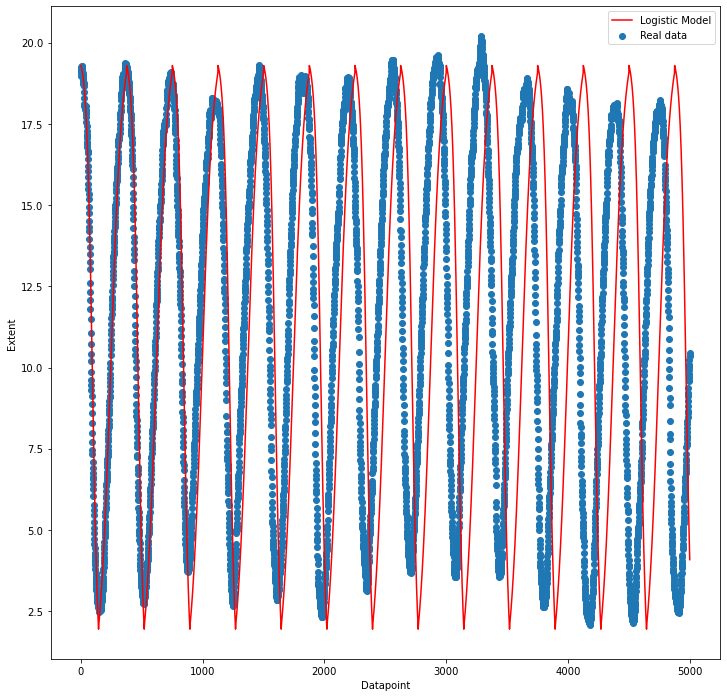

In [53]:
#Long-term changes noticed. 

plt.figure(figsize=(12,12))
plt.scatter(x_pred,y_pred)
plt.plot(x_pred, predict(l,m,n), color="red")

plt.legend([ 'Logistic Model', 'Real data'])
plt.xlabel('Datapoint')
plt.ylabel('Extent')

plt.show()

### 2. Changing the growth cycle by 10 days decrease.

In [54]:
data_growth = data_south.iloc[-210:,:]

data_growth

,Year,Month,Day,Datapoints,Extent
21144,2005,2,24,7968,2.893
21145,2005,2,25,7969,2.890
21146,2005,2,26,7970,2.897
21147,2005,2,27,7971,3.046
21148,2005,2,28,7972,3.047
...,...,...,...,...,...
21349,2005,9,17,8173,18.746
21350,2005,9,18,8174,18.868
21351,2005,9,19,8175,18.858
21352,2005,9,20,8176,18.938


In [55]:
#Restarting our "Datapoints" from the first date of forecasting.

data_growth.drop('Datapoints', inplace=True, axis=1)

a=[]
for i in range(1,211):
    a.append(i)
data_growth.insert(3, column = "Datapoints", value = a) 

data_growth

/Users/bhavnasharma/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Year,Month,Day,Datapoints,Extent
21144,2005,2,24,1,2.893
21145,2005,2,25,2,2.890
21146,2005,2,26,3,2.897
21147,2005,2,27,4,3.046
21148,2005,2,28,5,3.047
...,...,...,...,...,...
21349,2005,9,17,206,18.746
21350,2005,9,18,207,18.868
21351,2005,9,19,208,18.858
21352,2005,9,20,209,18.938


In [56]:
#Re-optimising a, b, and c values.

x = np.array(data_growth['Datapoints'])
y = np.array(data_growth['Extent'])

(a, b, c), cov = optimal.curve_fit(my_logistic_growth1, x, y, bounds = bounds, p0=p0)

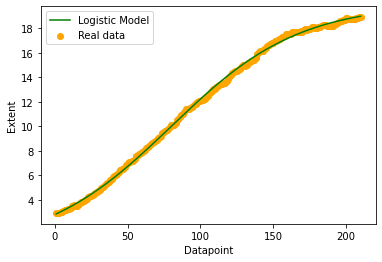

In [57]:
#Not much short term change. 

plt.scatter(x,y, color='orange')
plt.plot(x, my_logistic_growth2(x), color='green')

plt.legend([ 'Logistic Model', 'Real data'])
plt.xlabel('Datapoint')
plt.ylabel('Extent')
plt.show()

In [58]:
#Remaking the model with changed cycles.

def predict(l,m,n):
    d0=date(2005,9,21)
    y_model=[]
    w=[]
    for i in range(len(l)):
        d1=date(l[i],m[i],n[i])
        delt=d1-d0
        w.append(delt.days)
    r=1
    for k in w:
        if(k>0):
            g=k
            r=1
            while((r%2!=0 and g>145) or (r%2==0 and g>210)):
                if(k>145):
                    g-=145
                    r+=1
                    if(g>210):
                        g-=210
                        r+=1
            if(r%2!=0):
                y_model.append(my_logistic_decay2(g))
            else:
                y_model.append(my_logistic_growth2(g))
        elif(k==0):
            y_model.append(my_logistic_growth2(210))
        else:
            g=k
            r=1
            while(g<0):
                g+=210
                if(g>0 and r%2==0):
                    r+=1
                if(g==0 and r%2!=0):
                    g=145
                    r+=1
                elif(g==0):
                    g=145
                elif(g<0):
                    g+=145
                    if(r%2!=0):
                        r+=1
                    if(g==0):
                        g=210
                        r+=1
            if(r%2!=0):
                y_model.append(my_logistic_growth2(g))
            else:
                y_model.append(my_logistic_decay2(g))
        
            
    return y_model

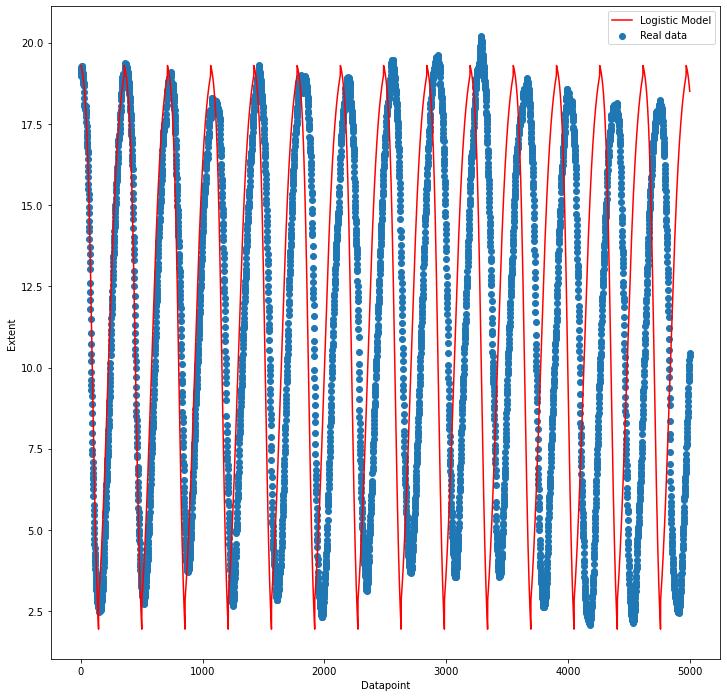

In [59]:
#Long-term changes noticed. 

plt.figure(figsize=(12,12))
plt.scatter(x_pred,y_pred)
plt.plot(x_pred, predict(l,m,n), color="red")

plt.legend([ 'Logistic Model', 'Real data'])
plt.xlabel('Datapoint')
plt.ylabel('Extent')

plt.show()

### 3. Training the model on data that is 15 years older than our current training model (expected change due to climate conditions). 

In [60]:
data_growth = data_south.iloc[-6060:-5840,:]

data_growth

,Year,Month,Day,Datapoints,Extent
15294,1989,2,18,2118,2.729
15295,1989,2,19,2119,2.731
15296,1989,2,20,2120,2.723
15297,1989,2,21,2121,2.747
15298,1989,2,22,2122,2.825
...,...,...,...,...,...
15509,1989,9,21,2333,18.134
15510,1989,9,22,2334,18.232
15511,1989,9,23,2335,18.274
15512,1989,9,24,2336,18.245


In [61]:
#Restarting our "Datapoints" from the first date of forecasting.

data_growth.drop('Datapoints', inplace=True, axis=1)

a=[]
for i in range(1,221):
    a.append(i)
data_growth.insert(3, column = "Datapoints", value = a) 

data_growth

/Users/bhavnasharma/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Year,Month,Day,Datapoints,Extent
15294,1989,2,18,1,2.729
15295,1989,2,19,2,2.731
15296,1989,2,20,3,2.723
15297,1989,2,21,4,2.747
15298,1989,2,22,5,2.825
...,...,...,...,...,...
15509,1989,9,21,216,18.134
15510,1989,9,22,217,18.232
15511,1989,9,23,218,18.274
15512,1989,9,24,219,18.245


In [62]:
#Re-optimising a, b, and c values.

x = np.array(data_growth['Datapoints'])
y = np.array(data_growth['Extent'])

(a, b, c), cov = optimal.curve_fit(my_logistic_growth1, x, y, bounds = bounds, p0=p0)

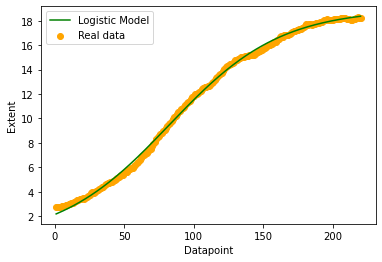

In [63]:
#Re-training the growth model.

plt.scatter(x,y, color='orange')
plt.plot(x, my_logistic_growth2(x), color='green')

plt.legend([ 'Logistic Model', 'Real data'])
plt.xlabel('Datapoint')
plt.ylabel('Extent')
plt.show()

In [64]:
data_decay = data_south.iloc[-6205:-6060,:]

data_decay

,Year,Month,Day,Datapoints,Extent
15149,1988,9,26,1973,18.508
15150,1988,9,27,1974,18.474
15151,1988,9,28,1975,18.483
15152,1988,9,29,1976,18.518
15153,1988,9,30,1977,18.563
...,...,...,...,...,...
15289,1989,2,13,2113,2.855
15290,1989,2,14,2114,2.819
15291,1989,2,15,2115,2.772
15292,1989,2,16,2116,2.748


In [65]:
#Restarting our "Datapoints" from the first date of forecasting.

data_decay.drop('Datapoints', inplace=True, axis=1)

v=[]
for i in range(1,146):
    v.append(i)
data_decay.insert(3, column = "Datapoints", value = v) 

data_decay

/Users/bhavnasharma/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Year,Month,Day,Datapoints,Extent
15149,1988,9,26,1,18.508
15150,1988,9,27,2,18.474
15151,1988,9,28,3,18.483
15152,1988,9,29,4,18.518
15153,1988,9,30,5,18.563
...,...,...,...,...,...
15289,1989,2,13,141,2.855
15290,1989,2,14,142,2.819
15291,1989,2,15,143,2.772
15292,1989,2,16,144,2.748


In [66]:
#Re-optimising a, b, and c values.

x2 = np.array(data_decay['Datapoints'])
y2 = np.array(data_decay['Extent'])

(a2, b2, c2), cov2 = optimal.curve_fit(my_logistic_decay1, x2, y2, bounds = bounds2, p0=p0)

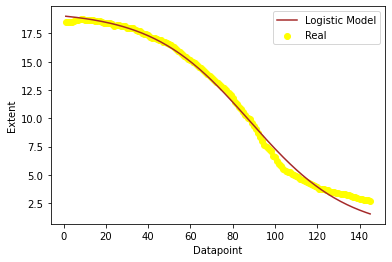

In [67]:
#Re-training the decay model.

plt.scatter(x2, y2, color='yellow')
plt.plot(x2, my_logistic_decay2(x2), color = 'brown')



plt.legend(['Logistic Model', 'Real'])
plt.xlabel('Datapoint')
plt.ylabel('Extent')
plt.show()

In [68]:
#Re-modelling.

def predict(l,m,n):
    d0=date(1989,9,25)
    y_model=[]
    w=[]
    for i in range(len(l)):
        d1=date(l[i],m[i],n[i])
        delt=d1-d0
        w.append(delt.days)
    r=1
    for k in w:
        if(k>0):
            g=k
            r=1
            while((r%2!=0 and g>145) or (r%2==0 and g>220)):
                if(k>145):
                    g-=145
                    r+=1
                    if(g>220):
                        g-=220
                        r+=1
            if(r%2!=0):
                y_model.append(my_logistic_decay2(g))
            else:
                y_model.append(my_logistic_growth2(g))
        elif(k==0):
            y_model.append(my_logistic_growth2(220))
        else:
            g=k
            r=1
            while(g<0):
                g+=220
                if(g>0 and r%2==0):
                    r+=1
                if(g==0 and r%2!=0):
                    g=145
                    r+=1
                elif(g==0):
                    g=145
                elif(g<0):
                    g+=145
                    if(r%2!=0):
                        r+=1
                    if(g==0):
                        g=220
                        r+=1
            if(r%2!=0):
                y_model.append(my_logistic_growth2(g))
            else:
                y_model.append(my_logistic_decay2(g))
        
            
    return y_model

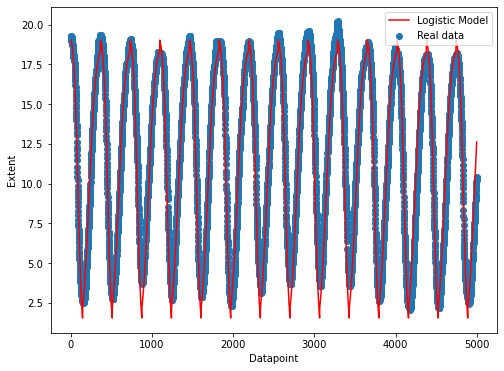

In [69]:
#Minor changes noticed. Given the unit of extent in real-world applications, these differences are highlighted.
plt.figure(figsize=(8,6))
plt.scatter(x_pred,y_pred)
plt.plot(x_pred, predict(l,m,n), color="red")

plt.legend([ 'Logistic Model', 'Real data'])
plt.xlabel('Datapoint')
plt.ylabel('Extent')

plt.show()

### 4. Assuming our original modelling data with the last observation date being - 21st Sept, 2005 is actually the Sea Ice Extent since 1990 and the last observation date is 21st Sept,1991.

In [70]:
#As we had already found our optimised cycles to be 220 for growth and 145 for decay, we create our cyclic model 
#with the same estimated cycle but with a different last observation date.

def predict(l,m,n):
    d0=date(1991,9,21)
    y_model=[]
    w=[]
    for i in range(len(l)):
        d1=date(l[i],m[i],n[i])
        delt=d1-d0
        w.append(delt.days)
    r=1
    for k in w:
        if(k>0):
            g=k
            r=1
            while((r%2!=0 and g>145) or (r%2==0 and g>220)):
                if(k>145):
                    g-=145
                    r+=1
                    if(g>220):
                        g-=220
                        r+=1
            if(r%2!=0):
                y_model.append(my_logistic_decay2(g))
            else:
                y_model.append(my_logistic_growth2(g))
        elif(k==0):
            y_model.append(my_logistic_growth2(220))
        else:
            g=k
            r=1
            while(g<0):
                g+=220
                if(g>0 and r%2==0):
                    r+=1
                if(g==0 and r%2!=0):
                    g=145
                    r+=1
                elif(g==0):
                    g=145
                elif(g<0):
                    g+=145
                    if(r%2!=0):
                        r+=1
                    if(g==0):
                        g=220
                        r+=1
            if(r%2!=0):
                y_model.append(my_logistic_growth2(g))
            else:
                y_model.append(my_logistic_decay2(g))
        
            
    return y_model

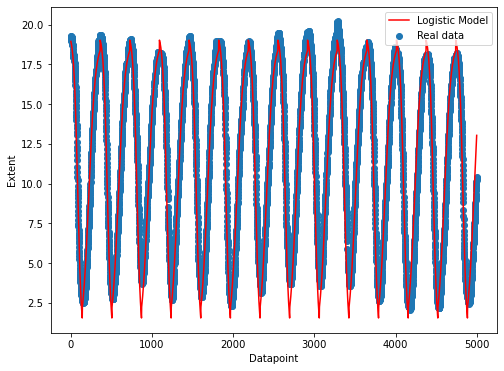

In [71]:
#Not much overall change observed.

x_pred = np.array(data_south_predict['Datapoints'])
y_pred = np.array(data_south_predict['Extent'])
l = np.array(data_south_predict['Year'])
m = np.array(data_south_predict['Month'])
n = np.array(data_south_predict['Day'])

plt.figure(figsize=(8,6))

plt.scatter(x_pred,y_pred)
plt.plot(x_pred, predict(l,m,n), color='red')

plt.legend([ 'Logistic Model', 'Real data'])
plt.xlabel('Datapoint')
plt.ylabel('Extent')

plt.show()

In [72]:
#Taking 900 records out of the holdout data to zoom in and check.
data_south_predict2 = data_south_predict.iloc[:900,:]

data_south_predict2

,Year,Month,Day,Datapoints,Extent
21354,2005,9,22,1,18.975
21355,2005,9,23,2,19.061
21356,2005,9,24,3,19.136
21357,2005,9,25,4,19.204
21358,2005,9,26,5,19.240
...,...,...,...,...,...
22249,2008,3,5,896,4.370
22250,2008,3,6,897,4.476
22251,2008,3,7,898,4.500
22252,2008,3,8,899,4.530


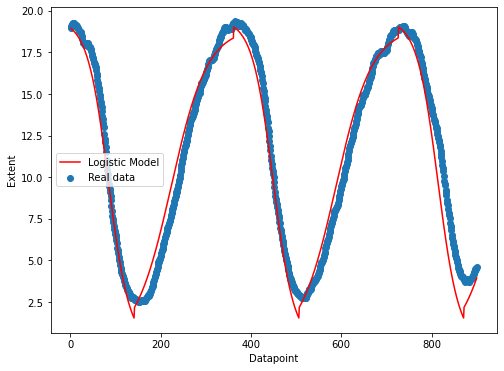

In [73]:
#Predicted logistic model of the 900 records out of the holdout data, including comparison between logistic model
#and real data.
#Minor noticeable changes.

x_pred2 = np.array(data_south_predict2['Datapoints'])
y_pred2 = np.array(data_south_predict2['Extent'])
l2 = np.array(data_south_predict2['Year'])
m2 = np.array(data_south_predict2['Month'])
n2 = np.array(data_south_predict2['Day'])

plt.figure(figsize=(8,6))

plt.scatter(x_pred2,y_pred2)
plt.plot(x_pred2, predict(l2,m2,n2), color="red")

plt.legend([ 'Logistic Model', 'Real data'])
plt.xlabel('Datapoint')
plt.ylabel('Extent')

plt.show()